In [1]:
import sys
sys.path.insert(0,'..')
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
import pandas as pd

from my_relu import ReLUAlpha

def get_mlp_network(relu_fn, batch_norm=False, nb_neurons=512, nb_hidden_layers=3):
    
    modules = [torch.nn.Linear(28 * 28, nb_neurons)]
    if batch_norm:
            modules.append(nn.BatchNorm1d(nb_neurons))
    for _ in range(nb_hidden_layers-1):
        modules.append(torch.nn.Linear(nb_neurons, nb_neurons))
        if batch_norm:
            modules.append(nn.BatchNorm1d(nb_neurons))
        modules.append(relu_fn())
    modules.append(torch.nn.Linear(nb_neurons, 10))

    return torch.nn.Sequential(*modules)


def copy_params(net1, net2):
    params1 = net1.named_parameters()
    params2 = net2.named_parameters()

    dict_params2 = dict(params2)
    for name, param in params1:
        if name in dict_params2:
            dict_params2[name].data.copy_(param.data)
    
    
relu_0 = lambda: ReLUAlpha(0)
relu_1 = lambda: ReLUAlpha(1)

def build_models(batchnorm, precision=32, nb_neurons=512, nb_hidden_layers=3):
    net1 = get_mlp_network(relu_0, batchnorm, nb_neurons, nb_hidden_layers)
    net2 = get_mlp_network(relu_1, batchnorm, nb_neurons, nb_hidden_layers)

    copy_params(net1, net2)

    for net in [net1, net2]:
        net.to(device)
        if precision == 16:
            net.half()
        if precision == 64:
            net.double()

    return net1, net2

In [29]:
nb_experiments = 100 #full paper experiment: nb_experiments = 1000
batch_size = 100
transform = transforms.ToTensor()
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

results = {}
for precision in tqdm([16, 32, 64], desc='precision'):
    count = 0
    if precision == 64:
        nb_experiments = 10
    for run_id in tqdm(range(nb_experiments), desc='run', leave=False):
        (net1, net2) = build_models(False, precision=precision, nb_neurons=256, nb_hidden_layers=3)
        for i, (x, y) in enumerate(train_loader):
            x = x.to(device)
            if precision == 16:
                x = x.half()
            if precision == 64:
                x = x.double()
            y = y.to(device)
            same = True
            y1 = net1(x.view(-1, 28 * 28))
            y2 = net2(x.view(-1, 28 * 28))
            loss = nn.CrossEntropyLoss()(y1, y) + nn.CrossEntropyLoss()(y2, y)
            loss.backward()
            if not torch.equal(net1[0].weight.grad, net2[0].weight.grad):
                count += 1
                break
    results[precision] = count / nb_experiments
for k in results:
    print(f'Ratio of theta in S in {k} bits: {results[k]}')

precision:   0%|          | 0/3 [00:00<?, ?it/s]

run:   0%|          | 0/200 [00:00<?, ?it/s]

run:   0%|          | 0/200 [00:00<?, ?it/s]

run:   0%|          | 0/1 [00:00<?, ?it/s]

Ratio of theta in S in 16 bits: 1.0
Ratio of theta in S in 32 bits: 0.445
Ratio of theta in S in 64 bits: 0.0


In [ ]:
nb_experiments = 100 #full paper experiment: nb_experiments = 1000
batch_size = 256
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)

df = pd.DataFrame(columns=["batchnorm", "same", "precision", "batch_idx", "run_id",
                           "net1_L1", "net1_L2", "net2_L1", "net2_L2", "diff_L1", "diff_L2"])
device = 'cuda' if torch.cuda.is_available() else 'cpu'

for precision in tqdm([16, 32, 64], desc='precision'):
    if precision == 64:
        nb_experiments = 10
    for batchnorm in tqdm([False], desc='batchnorm', leave=False):
        for run_id in tqdm(range(nb_experiments), desc='run', leave=False):
            (net1, net2) = build_models(batchnorm, precision=precision, nb_neurons=256, nb_hidden_layers=3)
            for i, (x, y) in enumerate(train_loader):
                x = x.to(device)
                if precision == 16:
                    x = x.half()
                if precision == 64:
                    x = x.double()
                y = y.to(device)
                same = True
                y1 = net1(x.view(-1, 28 * 28))
                y2 = net2(x.view(-1, 28 * 28))
                loss = nn.CrossEntropyLoss()(y1, y) + nn.CrossEntropyLoss()(y2, y)
                loss.backward()
                if not torch.equal(net1[0].weight.grad, net2[0].weight.grad):
                    same = False
                diff = net1[0].weight.grad - net2[0].weight.grad
                df = df.append({"run_id": run_id,
                                "batchnorm": batchnorm,
                                "same": same,
                                "precision": precision,
                                "net1_L1": torch.linalg.norm(net1[0].weight.grad.view(-1), 1).item(),
                                "net1_L2": torch.linalg.norm(net1[0].weight.grad.view(-1), 2).item(),
                                "net2_L1": torch.linalg.norm(net2[0].weight.grad.view(-1), 1).item(),
                                "net2_L2": torch.linalg.norm(net2[0].weight.grad.view(-1), 2).item(),
                                "diff_L1": torch.linalg.norm(diff.view(-1), 1),
                                "diff_L2": torch.linalg.norm(diff.view(-1), 2),
                                "batch_idx": i}, ignore_index=True)
                if same == False:
                        break

file_path = os.path.join(outdir, "volume_estimation_sample_MNIST.csv")
df.to_csv(file_path)

In [2]:
#df = pd.read_csv('../paper_results/section_3/volume_estimation_by_sample_size_MNIST.csv')

In [3]:
import matplotlib.pyplot as plt

def prepare_volume_plot(df, max_size, batch_size):
    dfs = []
    for precision in [16, 32]:
        tmp = df[df['precision'] == precision]
        max_len = len(tmp.run_id.unique())
        tmp = tmp[['batch_idx', 'same']].groupby(['batch_idx']).sum().reset_index()
        tmp['div'] = (max_len-tmp['same'])/max_len
        for i in range(tmp.batch_idx.count(), max_size):
            tmp = tmp.append({"div": 1.,
                                "same": max_len,
                                "batch_idx": i}, ignore_index=True)
        tmp['batch_idx'] = tmp['batch_idx'] * batch_size
        tmp = tmp.astype({"div":float})
        dfs.append(tmp)
    return dfs[0], dfs[1]

def plot_volume_estimation(df, max_size, batch_size=128):
    df16, df32 = prepare_volume_plot(df, max_size, batch_size)
    
    plt.figure(figsize=(15,5))
    plt.plot(df32['batch_idx'], df32['div'].values, label='32 bits')
    plt.plot(df16['batch_idx'], df16['div'].values, label='16 bits')
    plt.fill_between(df32['batch_idx'].values, df32['div'].values, alpha=0.3)
    plt.fill_between(df16['batch_idx'].values, df16['div'].values, alpha=.3)
    leg = plt.legend(title="Precision", fontsize='25', title_fontsize='25', loc='lower right')
    plt.xlabel('sample size', fontsize='25');
    plt.ylabel('Ratio of ' + r'$\theta \in S$', fontsize='30');plt.yticks(fontsize='25');
    plt.xticks(fontsize='25');
    for line in leg.get_lines():
        line.set_linewidth(10.0)

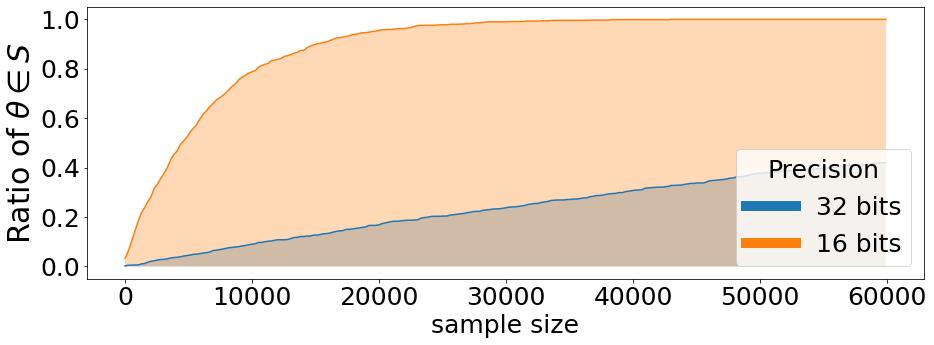

In [4]:
plot_volume_estimation(df[df['batchnorm']==False], 235, batch_size=256)

In [5]:
nb_experiments = 1000
batch_size = 256
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)

df = pd.DataFrame(columns=["batchnorm", "same", "precision", "batch_idx", "run_id",
                           "net1_L1", "net1_L2", "net2_L1", "net2_L2", "diff_L1", "diff_L2"])
device = 'cuda' if torch.cuda.is_available() else 'cpu'

for precision in tqdm([16, 32, 64], desc='precision'):
    if precision == 64:
        nb_experiments = 10
    for batchnorm in tqdm([False], desc='batchnorm', leave=False):
        for run_id in tqdm(range(nb_experiments), desc='run', leave=False):
            (net1, net2) = build_models(batchnorm, precision=precision, nb_neurons=256, nb_hidden_layers=3)
            opt = torch.optim.SGD([{'params': net1.parameters()}, {'params': net2.parameters()}], lr=0)
            for i, (x, y) in enumerate(train_loader):
                opt.zero_grad()
                x = x.to(device)
                if precision == 16:
                    x = x.half()
                if precision == 64:
                    x = x.double()
                y = y.to(device)
                same = True
                y1 = net1(x.view(-1, 28 * 28))
                y2 = net2(x.view(-1, 28 * 28))
                loss = nn.CrossEntropyLoss()(y1, y) + nn.CrossEntropyLoss()(y2, y)
                loss.backward()
                if not torch.equal(net1[0].weight.grad, net2[0].weight.grad):
                    same = False
                diff = net1[0].weight.grad - net2[0].weight.grad
                df = df.append({"run_id": run_id,
                                "batchnorm": batchnorm,
                                "same": same,
                                "precision": precision,
                                "net1_L1": torch.linalg.norm(net1[0].weight.grad.view(-1), 1).item(),
                                "net1_L2": torch.linalg.norm(net1[0].weight.grad.view(-1), 2).item(),
                                "net2_L1": torch.linalg.norm(net2[0].weight.grad.view(-1), 1).item(),
                                "net2_L2": torch.linalg.norm(net2[0].weight.grad.view(-1), 2).item(),
                                "diff_L1": torch.linalg.norm(diff.view(-1), 1).item(),
                                "diff_L2": torch.linalg.norm(diff.view(-1), 2).item(),
                                "batch_idx": i}, ignore_index=True)
                

file_path = os.path.join(outdir, "norm_diff_estimation_MNIST.csv")
df.to_csv(file_path)